# Poisson equation with complex numbers

Poisson equation (by method of manufactured solutions):

$$
\begin{align}
- \Delta u(x,y) &= f(x,y) \text{ in } \Omega \\
f(x,y) &= -1 - 2j \text{ in } \Omega \\
u(x,y) &= u_{exact}(x,y) \text{ on } \partial \Omega \\
u_{exact}(x,y) &= \frac{1}{2} x^2 + 1j \cdot y^2
\end{align}
$$

Weak form:

$$
\int_{\Omega} \nabla u \cdot \nabla \bar{v} = \int_{\Omega} f \bar{v}
$$

with the sesquilinear form:

$$
a(u,v) = \int_{\Omega} \nabla u \cdot \nabla \bar{v}
$$

and linear form:

$$
l(v) = \int_{\Omega} f \bar{v}
$$








In [48]:
import dolfinx
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
import ufl
from petsc4py import PETSc
from dolfinx.fem.petsc import assemble_vector
import pyvista
print(PETSc.ScalarType)
assert np.dtype(PETSc.ScalarType).kind == 'c'

<class 'numpy.complex128'>


In [49]:
# Define the mesh
mesh = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)

# Define the function spaces
V = dolfinx.fem.functionspace(mesh, ("Lagrange", 1))

In [50]:
# Define the exact solution (boundary condition for u)
u_c = dolfinx.fem.Function(V, dtype=np.complex128)
u_c.interpolate(lambda x:0.5*x[0]**2 + 1j*x[1]**2)

In [51]:
# Define test and trial functions
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Define the source term
f = dolfinx.fem.Constant(mesh, PETSc.ScalarType(-1 - 2j))

# Define the bilinear form
a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx

# Define the linear form
L = ufl.inner(f, v) * ufl.dx

In [52]:
# Define the boundary conditions
mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)
boundary_facets = dolfinx.mesh.exterior_facet_indices(mesh.topology)
boundary_dofs = dolfinx.fem.locate_dofs_topological(V, mesh.topology.dim-1, boundary_facets)
bc = dolfinx.fem.dirichletbc(u_c, boundary_dofs)

# Define the problem
problem = dolfinx.fem.petsc.LinearProblem(a, L, bcs=[bc])

# Solve the problem
uh = problem.solve()

In [53]:
# Define the exact solution
x = ufl.SpatialCoordinate(mesh)
u_ex = 0.5 * x[0]**2 + 1j*x[1]**2

# Compute the error
L2_error = dolfinx.fem.form(ufl.dot(uh-u_ex, uh-u_ex) * ufl.dx(metadata={"quadrature_degree": 5}))

# Compute the global and local error
local_error = dolfinx.fem.assemble_scalar(L2_error)
global_error = np.sqrt(mesh.comm.allreduce(local_error, op=MPI.SUM))

# Compute the maximum error
max_error = mesh.comm.allreduce(np.max(np.abs(u_c.x.array-uh.x.array)))

# Print the results
print(global_error, max_error)

(0.0007865435216227837+0.001766015633811332j) 3.5530783585733786e-06


In [54]:
# Plot with Pyvista
pyvista.start_xvfb()
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(mesh, mesh.topology.dim))
pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["u_real"] = uh.x.array.real
grid.point_data["u_imag"] = uh.x.array.imag
_ = grid.set_active_scalars("u_real")

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


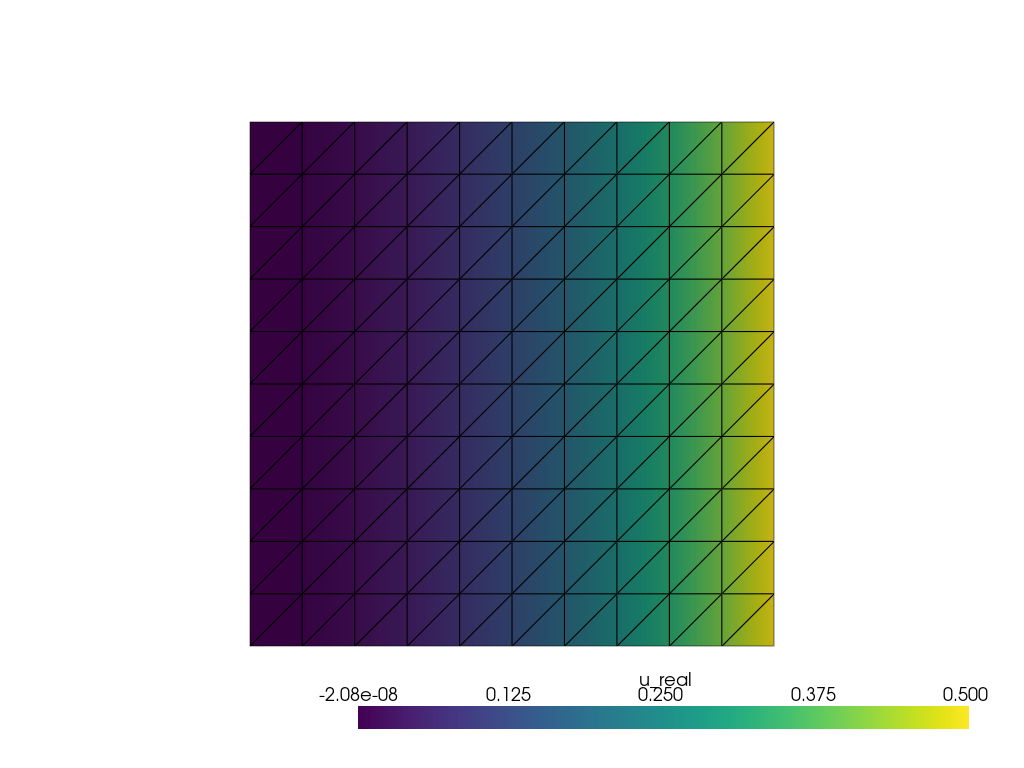

In [55]:
p_real = pyvista.Plotter()
p_real.add_mesh(grid, show_edges=True)
p_real.view_xy()
if not pyvista.OFF_SCREEN:
    p_real.show()

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


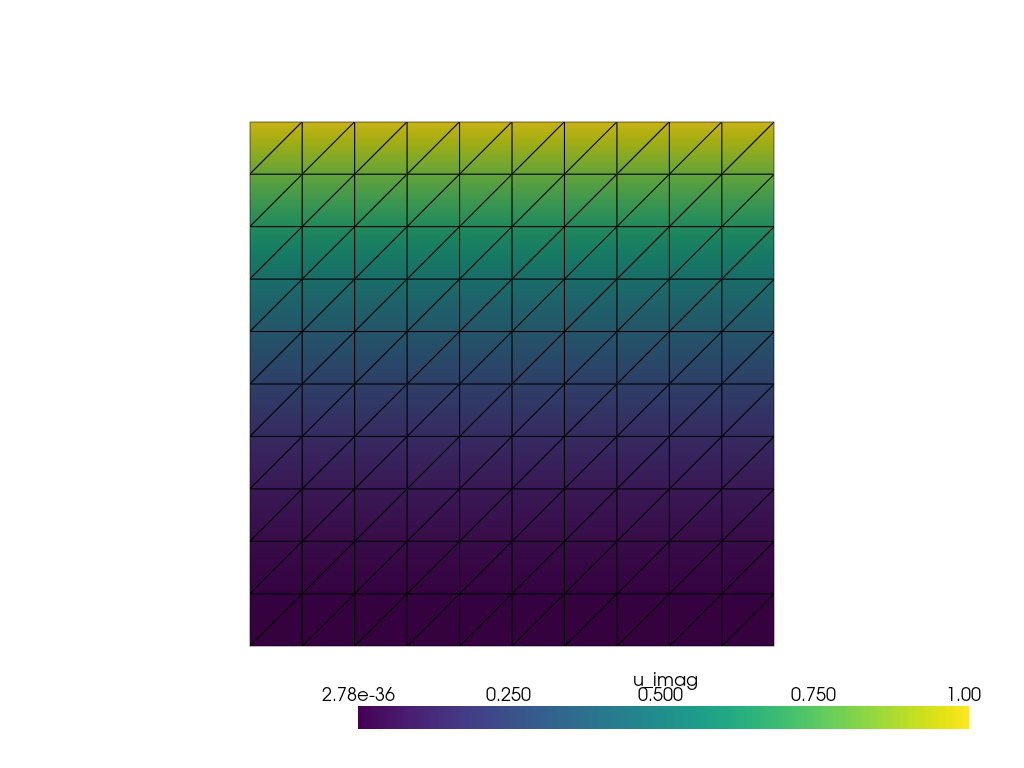

In [56]:
grid.set_active_scalars("u_imag")
p_imag = pyvista.Plotter()
p_imag.add_mesh(grid, show_edges=True)
p_imag.view_xy()
if not pyvista.OFF_SCREEN:
    p_imag.show()